In [1]:
using PlotlyJS, LinearAlgebra, NBInclude, StatsBase, Distributions

@nbinclude("Functions.ipynb")

run_examples = true

true

We use $C$ and $g(c, \mu, \sigma)$ from [Functions.ipynb](Functions.ipynb).

Mathemetical definitions are from https://en.xen.wiki/w/Categorical_Entropy,_Mutual_Information,_and_Channel_Capacity.

# Rényi Raw Monadic Categorical Entropy (Raw 1-CE)

$$H_a(X|Y=y) = \frac{a}{1-a}log{\lVert P(X|Y=y) \rVert _a}$$ 
$$\lVert P(X|Y=y) \rVert _a = (\sum_{x \in X}{{P(X=x|Y=y)}^a} )^{\frac{1}{a}}$$
$$P(X=x|Y=y) = P(Y=y|X=x)\frac{P(X=x)}{P(Y=y)}$$
$$P(Y=y) = \sum_{x \in X}{P(Y=y|X=x)P(X=x)}$$

In [20]:
function Raw1CE(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        a::Float64,             # Rényi entropy parameter, 1 < a < +inf
        σ::Float64,             # Dispersion of every note in cents
        notes::Vector{Float64}, # Notes in cents, in [0; 1200)
        P_x::Vector{Float64})   # Probabilities of notes, sum(P_x) = 1
    
    P_y_x = zeros(length(notes), length(C))
    i = 1
    for i in range(1, length(notes))
        P_y_x[i,:] = g.(C, notes[i], σ)
        i += 1
    end

    P_y = sum([P_y_x[i,:] .* P_x[i] for i in range(1, length(notes))])
    
    P_x_y = P_y_x .* (P_x ./ P_y')

    P_X_y_norm = [norm(P_x_y[:,j], a) for j in range(1, length(C))]

    CE = a/(1-a).*log.(P_X_y_norm)

    return CE, P_y
end

Raw1CE (generic function with 1 method)

### Raw 1-CE example


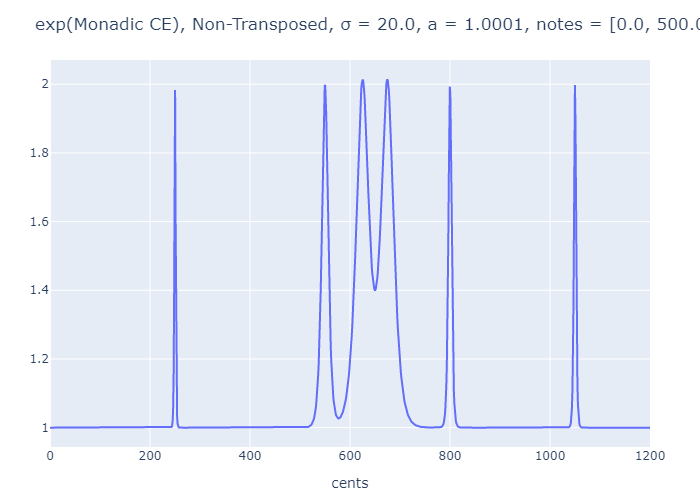

In [26]:
if run_examples
    a = 1.0001
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]
    P_x = [1/length(notes) for i in range(1, length(notes))]

    CE, _ = Raw1CE(C, a, σ, notes, P_x)

    CE = exp.(CE)
    p = plot(C, CE, Layout(
        title = "exp(Monadic CE), Non-Transposed, σ = $σ, a = $a, notes = $notes",
        xaxis_title = "cents"
    ))
    display(p)
end

# Rényi Transpositionally-Invariant Dyadic Categorical Entropy

Here $X=X_2$ and $Y=Y_2$
$$H_a^T(X|Y=y) = \frac{a}{1-a}log{\lVert P_T(X|Y=y) \rVert _a}$$ 
$$\lVert P_T(X|Y=y) \rVert _a = (\sum_{x \in X}{{P_T(X=x|Y=y)}^a} )^{\frac{1}{a}}$$
$$P_T(X=x|Y=y) = \int_{0}^{1200}{P(X=x,T=t|Y=y)dt}$$
$$P(X=x,T=t|Y=y) = P(Y=y|X=x,T=t)\frac{P(X=x,T=t)}{P(Y=y)}$$
$$P(Y=y) = \sum_{x \in X}{\sum_{t \in T}{P(Y=y|X=x,T=t)P(X=x,T=t)}}$$
Idk how to compute it effectively + we probably don't need this

# Average Categorical Entropy (ACE)

$$H(X|Y) = \sum_{y \in Y}{P(Y=y)H(X|Y=y)}$$

In [4]:
function ACE(P_y_arr::Vector{Float64}, CE_arr::Vector{Float64})
    return sum(P_y_arr .* CE_arr)
end

ACE (generic function with 1 method)

### ACE example

less ACE $\Rightarrow$ better new note

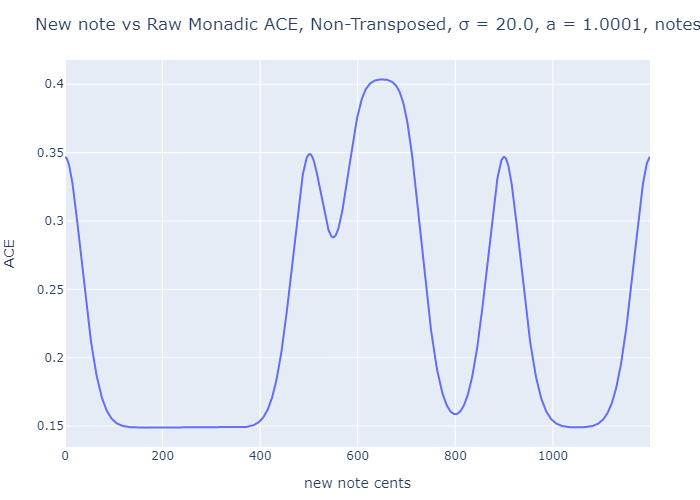

In [5]:
if run_examples
    a = 1.0001
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]

    newNoteCents = range(start=0, stop=1200, length=1201)[1:end-1]
    totalNumOfNotes = length(notes)+1
    P_x = [1/totalNumOfNotes for i in range(1, totalNumOfNotes)]
    ACEs = zeros(length(newNoteCents))

    for i in range(1, length(newNoteCents))
        CE_arr, P_y_arr = Raw1CE(C, a, σ, vcat(notes, newNoteCents[i]), P_x)
        ACEs[i] = ACE(P_y_arr, CE_arr)
    end

    p = plot(newNoteCents, ACEs, Layout(
        title = "New note vs Raw Monadic ACE, Non-Transposed, σ = $σ, a = $a, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "ACE"
    ))
    display(p)
end

# Categorical Mutual Information (CMI)

$$I(X;Y) = H(X)-H(X|Y)$$

# Output Entropy (OE)

$$I(X;Y) = I(Y;X) = H(Y) - H(Y|X) = H(Y) - H[G_s]$$  
$$s = const \implies exp(I(X;Y)) \propto exp(H(Y))$$
So instead of CMI we can use OE in iur purposes.

### Output Entropy example

bigger OE $\Rightarrow$ better new note

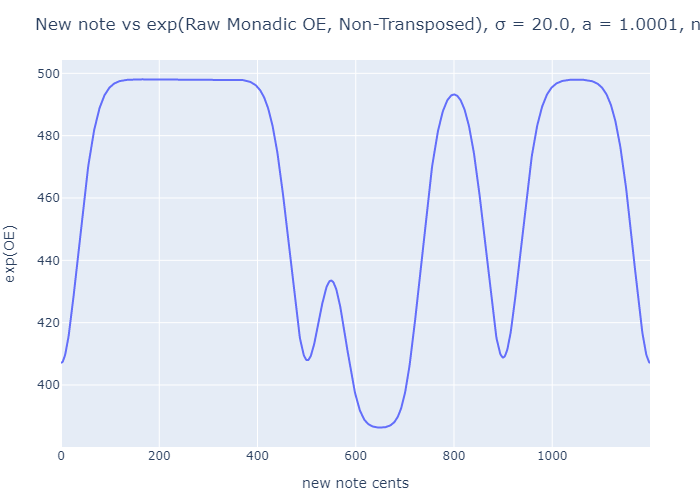

In [33]:
if run_examples
    a = 1.0001
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]

    newNoteCents = range(start=0, stop=1200, length=1201)[1:end-1]
    totalNumOfNotes = length(notes)+1
    P_x = [1/totalNumOfNotes for i in range(1, totalNumOfNotes)]
    OEs = zeros(length(newNoteCents))

    for i in range(1, length(newNoteCents))
        _, P_y_arr = Raw1CE(C, a, σ, vcat(notes, newNoteCents[i]), P_x)
        OEs[i] = renyientropy(P_y_arr, a)
    end

    OEs = exp.(OEs)
    p = plot(newNoteCents, OEs, Layout(
        title = "New note vs exp(Raw Monadic OE, Non-Transposed), σ = $σ, a = $a, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "exp(OE)"
    ))
    display(p)
end

# Dyadic OE, Transposed

$$ H(Y_2) = H(P(Y_2=y_2)) $$
$$ P(Y_2=y_2) = \sum_{x_2 \in X_2}{\sum_{t \in T}{P(Y_2=y_2|X_2=x_2,T=t)P(X_2=x_2,T=t)}} $$  

Idk how to calculate it efficiently, so I will calculate a slightly different value, but similar in meaning (I hope):

# Dyadic OE, Diagonal average
$$ H_{diag}(Y_1=y_1) = H(\frac{1}{|T|}\sum_{t \in T}{P(Y_2=\{(y_1+t)\mod{1200},t\})}) = 
H(\frac{1}{|T|}\sum_{t \in T}{P(Y_2=\{t, (y_1+t)\mod{1200}\})}), \quad T \subset C $$
$$ P(Y_2=y_2) = \sum_{x_2 \in X_2}{P(Y_2=y_2|X_2=x_2)P(X_2=x_2)} $$


In [7]:
# TODO: OPTIMIZE!!! VERY POOR PERFORMANCE!!!
# FIXME: exp(OE_diag) in example is too big, this of course does not affect
#        the relative results (which is what we need), but it is suspicious 

function DyadicOE_no_transp(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        σ::Float64,             # Dispersion of every note in cents
        notes::Vector{Float64}, # Notes in cents, in [0; 1200)
        P_x::Vector{Float64})   # Probabilities of notes, sum(P_x) = 1
    
    # dublicate and transpose by octave notes near border: [0; 3σ] and [1200-3σ; 1200]
    # we didn't do this in 1d situations because we used specially defined gaussian distribution 
    #     g from Functions.ipynb
    numOfNotes = length(notes)
    for i in range(1, numOfNotes)
        if notes[i] < 3*σ
            push!(notes, 1200+notes[i])
            push!(P_x, P_x[i])
        elseif notes[i] > 1200-3*σ
            push!(notes, notes[i]-1200)
            push!(P_x, P_x[i])
        end
    end
    numOfNotes = length(notes)

    numOfCents = length(C)
    P_y = zeros(numOfCents, numOfCents)
    C2 = [[ci, cj] for ci in C, cj in C]

    for i in range(1, numOfNotes)
        for j in range(1, numOfNotes)
            mv_norm_dist = MvNormal([notes[i], notes[j]], [σ^2 0; 0 σ^2])
            P_y = P_y .+ [pdf(mv_norm_dist, c2) for c2 in C2].*P_x[i].*P_x[j]
        end
    end

    return P_y
end


function DyadicOE_diag(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        a::Float64,             # Rényi entropy parameter, 1 < a < +inf
        σ::Float64,             # Dispersion of every note in cents
        notes::Vector{Float64}, # Notes in cents, in [0; 1200)
        P_x::Vector{Float64})   # Probabilities of notes, sum(P_x) = 1
    
    P_y = DyadicOE_no_transp(C, σ, notes, P_x)

    numCents = length(C)
    P_y_diag_sum = zeros(numCents)
    for j in 1:numCents
        for i in 1:numCents
            P_y_diag_sum[j] += P_y[i, mod(i + j - 2, numCents) + 1]
        end
    end
    
    return renyientropy(P_y_diag_sum./numCents, a)
end

DyadicOE_diag (generic function with 1 method)

### Dyadic OE with diagonal average example

bigger OE $\Rightarrow$ better new note

1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/300
139/

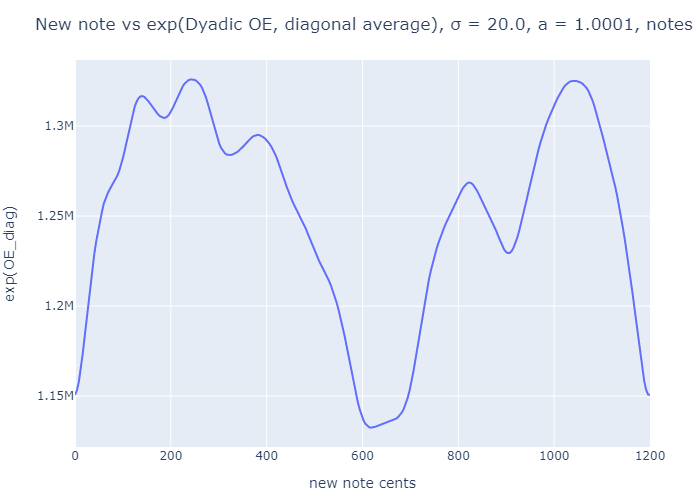

In [8]:
if run_examples
    a = 1.0001
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]

    newNoteCents = range(start=0, stop=1200, length=300)#[1:end-1]
    totalNumOfNotes = length(notes)+1
    P_x = [1/totalNumOfNotes for i in range(1, totalNumOfNotes)]
    OEs_diag = zeros(length(newNoteCents))

    C = range(start=0, stop=1200, length=300)#[1:end-1]

    for i in range(1, length(newNoteCents))
        println("$i/$(length(newNoteCents))")
        OEs_diag[i] = DyadicOE_diag(C, a, σ, vcat(notes, newNoteCents[i]), P_x)
    end

    OEs_diag = exp.(OEs_diag)
    p = plot(newNoteCents, OEs_diag, Layout(
        title = "New note vs exp(Dyadic OE, diagonal average), σ = $σ, a = $a, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "exp(OE_diag)"
    ))
    display(p)
end

# IOE (intervals' OE)
Dyadic OE (Transposed or Diagonal average) is similar (it seems so to me intuitively) to IOE (Monadic OE of intervals), interval is the distance from one note to another in cents: $$ z_i = |y_j-y_k|, \quad z_i \in Z, \quad y_j, y_k \in Y = Y_1 $$
So instead of $Y_2$ - space of pairs of notes we use $Z$ - space of intervals, which is one dimensonal. Probability of an interval $z_i$ is $x_i \in X$ and is equal to sum of products of the probabilities of the notes in pairs that form this interval.  

### IOE example
Problem: we have $n$ notes in the scale. We need to calculate IOE of the scale in which a note with a certain number of cents was added.  
  
Based on the problem, we can calculate the probabilities of all intervals from the given notes in the scale once, and then for each new note in the scale add the probabilities of intervals resulting from the new note and the old ones.  

bigger exp(IOE) $\Rightarrow$ better new note

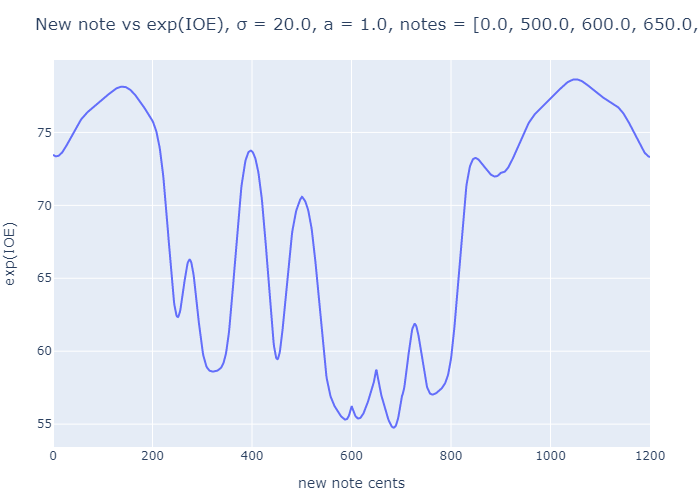

In [15]:
#calculate note's intervals probabilities of notes
function NIP(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        σ::Float64,                   # Dispersion of every interval in cents
        notes::Vector{Float64},       # Notes in cents, in [0; 1200)
        notes_noc::Vector{Int64})     # Notes' numbers of occurrence

    notes_probs = notes_noc./sum(notes_noc); # Probabilities of notes, sum(P_x) = 1

    NIP_arr = zeros(length(C))

    for i in 1:length(notes)
        for j in i:length(notes)
            interval = abs(notes[i] - notes[j])
            prob = notes_probs[i]*notes_probs[j]
            NIP_arr += g.(C, interval, σ)*prob
        end
    end

    return NIP_arr
end

#calculate note's intervals probabilities of notes + new note
#    NIP of notes without a new one is given
function NIP_new_note(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        NIP_arr::Vector{Float64},
        σ::Float64,                   # Dispersion of every interval in cents
        notes::Vector{Float64},       # Notes in cents, in [0; 1200)
        notes_noc::Vector{Int64},     # Notes' numbers of occurrence
        new_note::Float64,            # Cents of a new note
        new_note_noc::Int64)          # Number of occurrence of a new note

    #adjusting probabilities
    NIP_new_note_arr = NIP_arr .* (sum(notes_noc)/(sum(notes_noc) + new_note_noc))^2

    notes_probs = notes_noc./(sum(notes_noc) + new_note_noc)
    new_note_prob = new_note_noc/(sum(notes_noc) + new_note_noc)

    for i in 1:length(notes)
        interval = abs(notes[i] - new_note)
        prob = notes_probs[i]*1/new_note_prob
        NIP_new_note_arr += g.(C, interval, σ)*prob
    end

    return NIP_new_note_arr
end


function IOE(NIP_arr::Vector{Float64}, a::Float64)
    return renyientropy(NIP_arr, a)
end




if run_examples
    a = 1.
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]
    notes_noc = [1, 1, 1, 1, 1, 1]

    NIP_arr = NIP(C, σ, notes, notes_noc)

    newNoteCents = range(start=0, stop=1200, length=1200)
    IOEs = zeros(length(newNoteCents))

    C = range(start=0, stop=1200, length=1200)

    for i in range(1, length(newNoteCents))
        NIP_new_note_arr = NIP_new_note(C, NIP_arr, σ, notes, notes_noc, newNoteCents[i], 1)
        IOEs[i] = IOE(NIP_new_note_arr, a)
    end

    IOEs_exp = exp.(IOEs)
    p = plot(newNoteCents, IOEs_exp, Layout(
        title = "New note vs exp(IOE), σ = $σ, a = $a, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "exp(IOE)"
    ))
    display(p)
end

# COE (Combined OE's)

$$ COE = normalize(RMOE) \cdot normalize(IOE) $$
where RMOE is Raw Monadic OE.

In [16]:
# calculate Raw Monadic OE
function RMOE(
        C::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        a::Float64,                   # Rényi entropy parameter, 1 < a < +inf
        σ::Float64,                   # Dispersion of every note in cents
        notes::Vector{Float64},       # Notes in cents, in [0; 1200)
        notes_noc::Vector{Int})       # Notes' numbers of occurrence

    notes_probs = notes_noc./sum(notes_noc);

    RMOE = zeros(length(C))
    
    for i in 1:length(notes)
        RMOE += g.(C, notes[i], σ)*notes_probs[i]
    end

    return renyientropy(RMOE, a)
end


normalize(arr::Vector{Float64}) = (arr .- minimum(arr)) ./ (maximum(arr) - minimum(arr))


function COE(RMOE_arr::Vector{Float64}, IOE_arr::Vector{Float64})
    return normalize(RMOE_arr).*normalize(IOE_arr)
end

COE (generic function with 1 method)

### COE example

bigger COE $\Rightarrow$ better new note

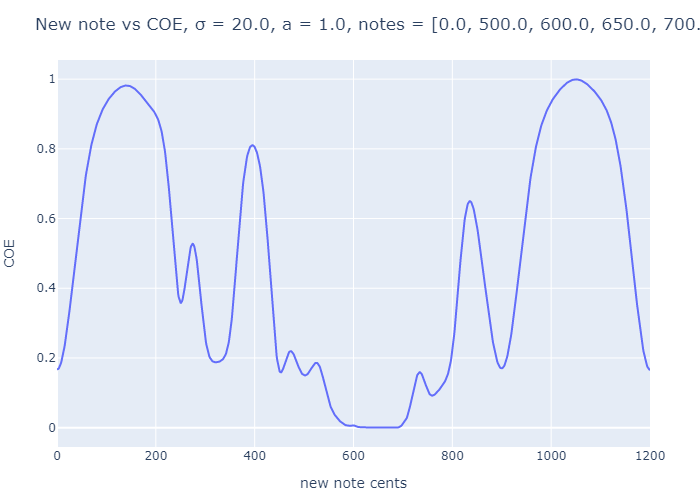

In [17]:
if run_examples
    a = 1.
    σ = 20.
    notes = [0., 500., 600., 650., 700., 900.]
    notes_noc = [1, 1, 1, 1, 1, 1]

    NIP_arr = NIP(C, σ, notes, notes_noc)

    newNoteCents = range(start=0, stop=1200, length=1200)
    IOEs = zeros(length(newNoteCents))
    RMOEs = zeros(length(newNoteCents))

    C = range(start=0, stop=1200, length=1200)

    for i in range(1, length(newNoteCents))
        RMOEs[i] = RMOE(C, a, σ, vcat(notes, newNoteCents[i]), vcat(notes_noc, 1))

        NIP_new_note_arr = NIP_new_note(C, NIP_arr, σ, notes, notes_noc, newNoteCents[i], 1)
        IOEs[i] = IOE(NIP_new_note_arr, a)
    end

    COEs = COE(RMOEs, IOEs)

    p = plot(newNoteCents, COEs, Layout(
        title = "New note vs COE, σ = $σ, a = $a, notes = $notes",
        xaxis_title = "new note cents",
        yaxis_title = "COE"
    ))
    display(p)
end